# Лабораторная работа № 3

## Выполнила: Егорова Вера

In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import skimage
from skimage.segmentation import slic, mark_boundaries
import sklearn
from sklearn.cluster import KMeans

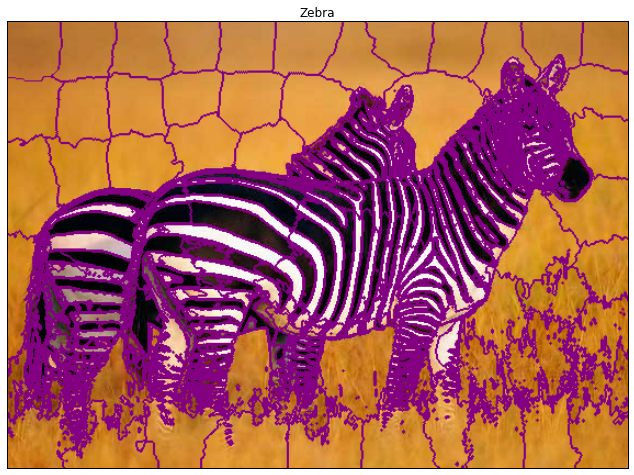

In [2]:
zebra_image = cv2.cvtColor(cv2.imread('zebra.jpg'), cv2.COLOR_BGR2RGB)
segments = slic(zebra_image)
plt.figure(figsize=(15, 8)) 
plt.imshow(mark_boundaries(zebra_image, segments, color=(125,0,125)))
plt.title('Zebra')
plt.xticks([])
plt.yticks([])
plt.show()

Получили некоторое разбиение на суперпиксили. Попробуем подобрать  подходящие параметры для функции skimage.segmentation.slic()):

<li> image - исходное изображение для сегментации <br>
<li> n_segments - (приблизительное) количество суперпикселей в разбиении <br>
<li> compactness - баланс между близостью пикселей по цвету и близостью пикселей по расстоянию. Чем больше значение compactness, тем больше отдается предпочтение пространственной близости, что длает суперпиксели более квадратными<br>
<li> max_iter - максимальное количество итерации алгоритма kMeans<br>
<li> sigma - ширина ядра сглаживания Гаусса. 
<li> spacing - регулирует веса между расстояниями вдоль z, y, x при кластеризации с помощью kMeans<br>
<li> multichannel - определяет, можно ли считать последнюю ось изображения как несколько какалов или как отдельную пространственную размерность<br>
<li>convert2lab - определяет, должно ли исходное изображение быть в цветовом пространстве Lab перед сегментацией<br>
<li>enforce_connectivity - определяет, должны ли основные сегменты быть соединны<br>
<li>min_size_factor - доля минимального размера сегмента, который будет удален в соответствии спредполагаемым сегментом размера depth*width*height/n_segments<br>
<li>max_size_factor - доля максимального размера связных сегментов<br>
<li>slic_zero - запустить алгоритм в режиме  SLIC-zero<br>

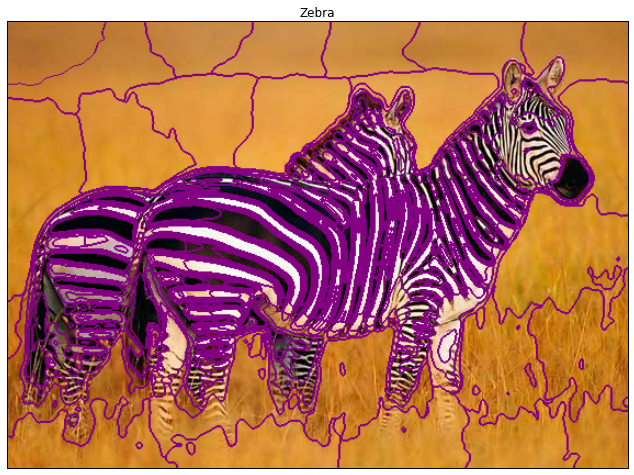

In [115]:
def get_segments(image, name, n, comp, sigma, spacing):
    segments = slic(image, n_segments=n, compactness=comp, sigma=sigma,
                    spacing=spacing)
    plt.figure(figsize=(15, 8)) 
    plt.imshow(mark_boundaries(image, segments, color=(125,0,125)))
    plt.title(name)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return segments

zebra_image = cv2.cvtColor(cv2.imread('zebra.jpg'), cv2.COLOR_BGR2RGB)
zebra_segments = get_segments(zebra_image, 'Zebra', 50, 3, 5, (5, 2, 2))

In [182]:
def segment_hist(segment_data):
    b, g, r = np.zeros(256), np.zeros(256), np.zeros(256),
    for pixel in segment_data:
        b[pixel[0]] += 1
        g[pixel[1]] += 1
        r[pixel[2]] += 1
    b /= np.max(b)
    r /= np.max(r)
    g /= np.max(g)
    return list(b) + list(g) + list(r)
    
def get_segment_features(segment_data):
    features = list(np.mean(segment_data, axis=0))
    #features += list(np.var(segment_data, axis=0))
    features += list(np.max(segment_data, axis=0))
    features += list(np.min(segment_data, axis=0))
    features += list(segment_hist(segment_data))
    return features

def get_features(image, segments):
    return [get_segment_features(image[segments == i]) 
            for i in xrange(np.max(segments)+1)]

zebra_features = get_features(zebra_image, zebra_segments)

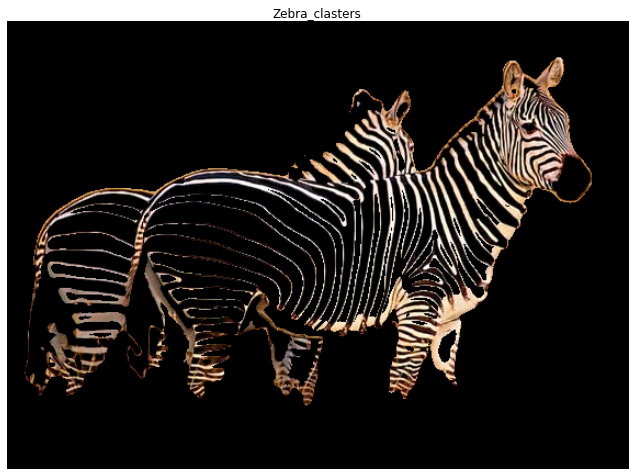

In [219]:
def get_clusters(image, segments, features,clusters):
    clf = KMeans(n_clusters=clusters, random_state=100)
    clusters = clf.fit_predict(features)
    new_segments = np.array(segments)
    for i in xrange(len(new_segments)):
        for j in xrange(len(new_segments[i])):
            new_segments[i][j] = clusters[segments[i][j]]
    return new_segments
zebra_image = cv2.cvtColor(cv2.imread('zebra.jpg'), cv2.COLOR_BGR2RGB)
new_segments = get_clusters(zebra_image, zebra_segments, zebra_features, 2)
plt.figure(figsize=(15, 8)) 
zebra_image[new_segments == 0] = (0, 0, 0)
plt.imshow(zebra_image)
plt.title('Zebra_clasters')
plt.xticks([])
plt.yticks([])
plt.show()

Видим, что зебры были успешно выделены на изображении.

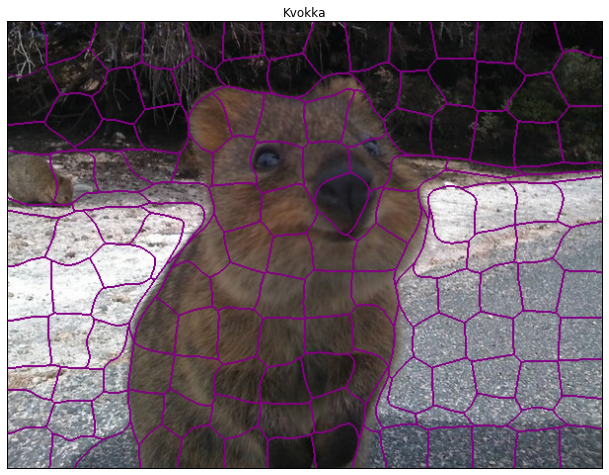

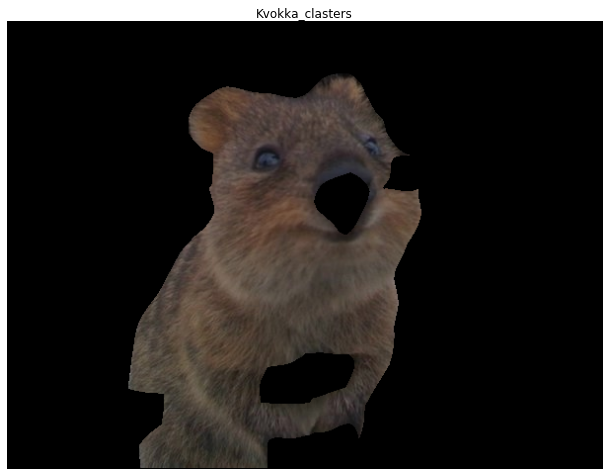

In [247]:
kvokka_image = cv2.cvtColor(cv2.imread('kvokka.jpg'), cv2.COLOR_BGR2RGB)
kvokka_segments = get_segments(kvokka_image, 'Kvokka', 150, 3, 35, (1,5,5))
kvokka_features = get_features(kvokka_image, kvokka_segments)
new_segments = get_clusters(kvokka_image, kvokka_segments, kvokka_features, 5)
plt.figure(figsize=(15, 8)) 
kvokka_image[new_segments != 1] = (0, 0, 0)
plt.imshow(kvokka_image)
plt.title('Kvokka_clasters')
plt.xticks([])
plt.yticks([])
plt.show()

Нос и темные пятна на шерсти квокки сильно уж похожи на внешний фон (по гистограмме, средней интенсивноси), наверное поэтому они так же были отнесены к фону.

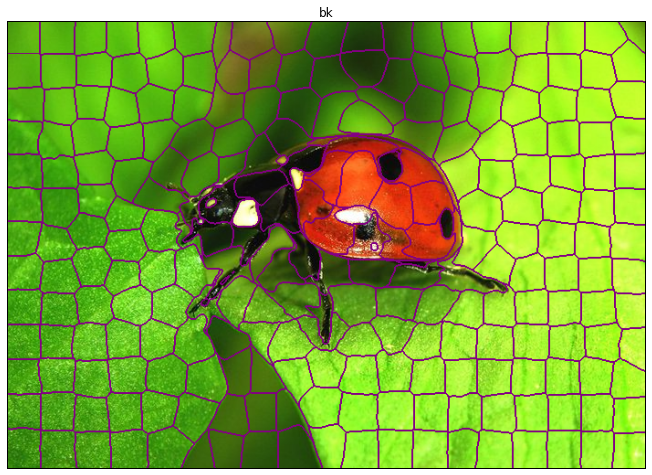

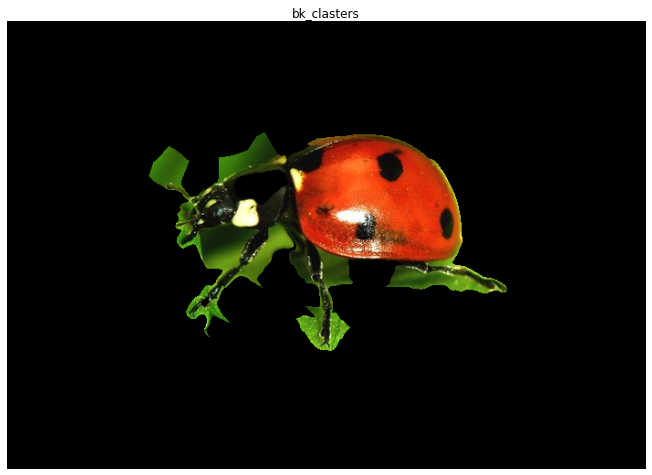

In [249]:
bk_image = cv2.cvtColor(cv2.imread('bk.jpg'), cv2.COLOR_BGR2RGB)
bk_segments = get_segments(bk_image, 'bk', 250, 15, 5, (2, 2, 2))
bk_features = get_features(bk_image, bk_segments)
new_segments = get_clusters(bk_image, bk_segments, bk_features, 3)
plt.figure(figsize=(15, 8)) 
bk_image[new_segments != 1] = (0, 0, 0)
#bk_image[new_segments == 2] = (0, 0, 0)
plt.imshow(bk_image)
plt.title('bk_clasters')
plt.xticks([])
plt.yticks([])
plt.show()

В целом божья коровка была успешно обнаружена. Тонкие элементы божьей коровки (лапки,  усики) были включены вместе с частью зеленого фона, потому что, в супепиксель они входили тоже вместе с зеленым фоном. Возможно, стоило попробовать значительно увеличить количество суперпикселей, чтобы они были сопоставимы по размеру с лапками и усиками божьей коровки.